In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from utils.data_utils import *

In [8]:
# 更改 utils/data_utils.py 中的自訂 function 可重新 reload
from importlib import reload
from utils import data_utils
reload(data_utils)
from utils.data_utils import *

# Read data

In [9]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
load = pd.read_pickle(path + 'load_nyisocom.pickle')
print(f'原始資料數量: {load.shape}')

原始資料數量: (2174180, 3)


In [10]:
# 2005-01-31 之前, NYC 和 LONG IL 是並在一起, 資料不適合使用
load = load[(load['Date']>='2005-01-31 00:00:00')]
print(f'原始資料數量: {load.shape}')

原始資料數量: (1823975, 3)


# Clean data

## unusal values

### Explore

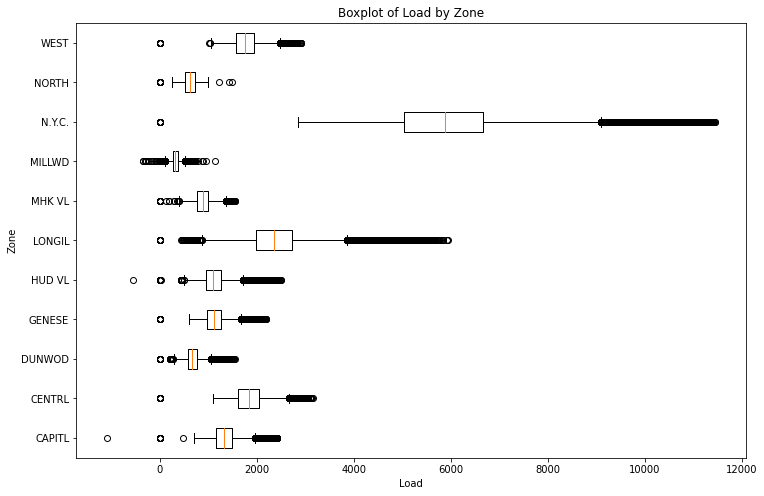

In [11]:
df = load

load_data_by_zone = []
# 遍歷每個類別，將相應的Load數據添加到列表中
for zone, data in df.groupby('Zone')['Load']:
    load_data_by_zone.append(data)

# 繪製箱形圖
plt.figure(figsize=(12, 8))
plt.boxplot(load_data_by_zone, labels=df['Zone'].unique(), vert=False)
plt.xlabel('Load')
plt.ylabel('Zone')
plt.title('Boxplot of Load by Zone')
plt.show()

### Remove 0 and negative

In [12]:
print(f'刪除前資料數量: {df.shape}')
non_pos = df[df['Load']<=0]
print(f'小於等於0的數量: {non_pos.shape}')
load_drop = df.drop(non_pos.index) 
print(f'刪除後資料數量: {load_drop.shape}')

刪除前資料數量: (1823975, 3)
小於等於0的數量: (115, 3)
刪除後資料數量: (1823860, 3)


## duplicate


### Explore

In [13]:
df = load_drop

# 確認有多少重複值
duplicates = df[df.duplicated(subset=['Date', 'Zone'])]
print(f'重複筆數：{duplicates.shape}')

print(duplicates.head(1))
df[(df['Date'] == '2014-11-02 01:00:00')&(df['Zone']=='DUNWOD')]

重複筆數：(175, 3)
                      Date    Zone    Load
490148 2005-03-26 01:00:00  CENTRL  1693.6


,Date,Zone,Load
1812708,2014-11-02 01:00:00,DUNWOD,530.3
1812709,2014-11-02 01:00:00,DUNWOD,508.5


### Take an average of duplicates

In [14]:
df= load_drop


# 重複中有兩筆資料的取平均
print(f'刪除前資料數量: {df.shape}')
duplicates_2 = df[df.duplicated(subset=['Date', 'Zone'])]
print(f'type2 重複筆數: {duplicates_2.shape}')
df_drop = df.groupby(['Date', 'Zone'])['Load'].mean().reset_index()
print(f'刪除後資料數量: {df_drop.shape}')

load_drop = df_drop

刪除前資料數量: (1823860, 3)
type2 重複筆數: (175, 3)
刪除後資料數量: (1823685, 3)


## NA 

In [15]:
df = load_drop

print(f'目前資料數量: {df.shape}')
df_all_time = merge_all_time(df)
print(f'補上所有時間後資料數量: {df_all_time.shape}')

min_date = df['Date'].min(); max_date = df['Date'].max()
print(f'min: {min_date}')
print(f'max: {max_date}')

# 驗算
hours_df = pd.DataFrame({'Date': pd.date_range(start = df['Date'].min(), end = df['Date'].max(), freq = '1H') })
print(f'驗算 - 所有時間點 x 11 zones:{hours_df.shape[0]*11}')



df_all_time = df_all_time

目前資料數量: (1823685, 3)
補上所有時間後資料數量: (1823976, 3)
min: 2005-01-31 00:00:00
max: 2023-12-31 23:00:00
驗算 - 所有時間點 x 11 zones:1823976


### Explore: 以 NYC 為例

In [ ]:
df = df_all_time

# 找尋 one zone 的 NA
zone = 'N.Y.C.'
df_onezone = df.loc[df['Zone'] == zone,]
print(f"NYC 資料數量: {df_onezone.shape}")
print(f"NYC NA number: {df_onezone['Load'].isna().sum()}") 

df_onezone = df_onezone

NYC 資料數量: (165816, 3)
NYC NA number: 28


#### visualize NA on heatmap

In [ ]:
df = df_onezone

# 呈現 NA heatmap
# vis_na(df, figsize_width = 16, figsize_height = 80) # (END) ALL 至 2023-09-23 23:00:00 (154536)

In [ ]:
df = df_onezone

# 計算年 NA
year_na_count = count_year_na(df)
year_na_count.to_frame()

,Load
Date,
2005-12-31,5
2006-12-31,4
2007-12-31,1
2008-12-31,1
2009-12-31,1
2010-12-31,2
2011-12-31,1
2012-12-31,1
2013-12-31,1


### Impute: All zones 每個區域用STL各自補

In [ ]:
df = df_all_time

'''
確認：呈現每個區域總NA值和分年NA值，確認 select_period 是否只看一個 zone 就決定
'''
total_na, month_na = count_zone_na(df)
print(total_na)
# for i in range(len(month_na)):
#     print(month_na[i])

[29, 28, 28, 28, 29, 28, 28, 42, 28, 28, 28]


#### 先補 NYC

STL 補值後 NA number: 0


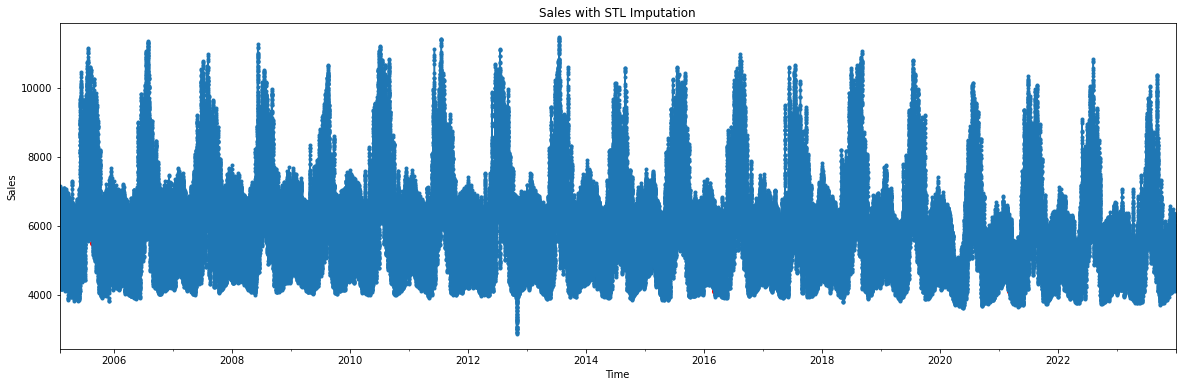

In [ ]:
df = df_all_time.loc[df_all_time['Zone'] == 'N.Y.C.']

df_impute_stl, imputed_indices = impute_stl(df)
print(f"STL 補值後 NA number: {df_impute_stl['Load'].isna().sum()}")

plot_impute_result(df_impute_stl, imputed_indices)

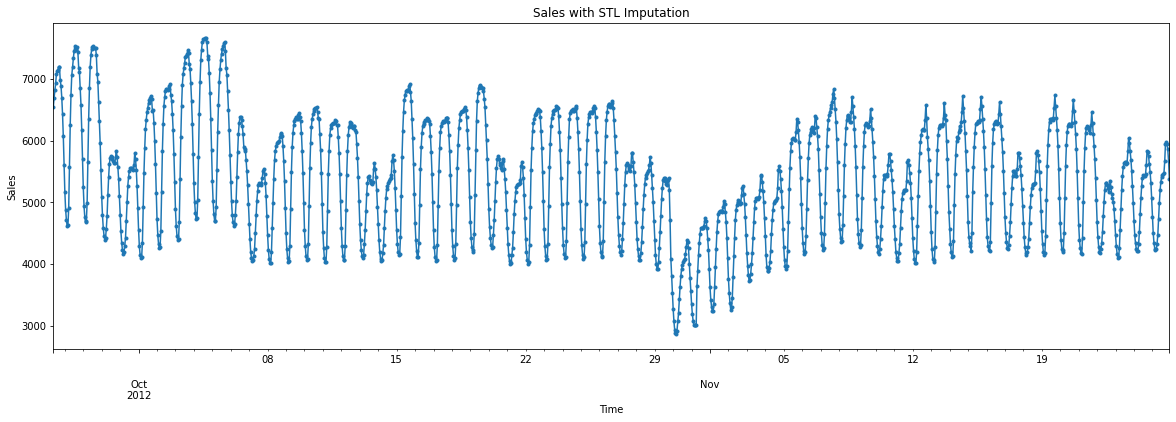

In [ ]:
# # explore the lowest part
# df = df_impute_stl.iloc[67089:68543,]

# plt.figure(figsize=[20, 6])
# df['Load'].plot(style='.-',  label='Load')

# plt.title("Sales with STL Imputation")
# plt.ylabel("Sales")
# plt.xlabel("Time")
# plt.show()

In [108]:
# Date 從 index 轉成 columne
df_one = df_impute_stl
df_one['Date'] = df_one.index
df_one = df_one.reset_index(drop=True)

# 存成 list (train_test_select 吃 list)
df_impute_stl_ls = [df_one] 

In [109]:
file_name = "nyiso_NYC_impute_stl.pkl" 

path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
open_file = open(path + file_name, "wb")
pickle.dump(df_impute_stl_ls, open_file)
open_file.close()

#### All

In [38]:
df = df_all_time

'''
做補值：每個區域各自補
Time: About 11.5 mins
'''
zones = df['Zone'].unique()
# zones = ['CAPITL', 'N.Y.C.']
all_impute_stl = []
imputed_indices_ls = []
for zone in zones: # 11

    # one zone in one loop
    result = df.loc[df['Zone'] == zone,]
    # imputation
    impute_result, imputed_indices = impute_stl(result)
    # index -> column
    impute_result['Date'] = impute_result.index
    impute_result = impute_result.reset_index(drop=True)  
    # save in a list
    all_impute_stl.append(impute_result)
    imputed_indices_ls.append(imputed_indices)
    
all_impute_stl_ls = [pd.concat(all_impute_stl, axis=0)]

In [39]:
# 上面轉換花費太多時間，儲存成 pkl

file_name = "nyiso_all_impute_stl.pkl"

path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
open_file = open(path + file_name, "wb")
pickle.dump(all_impute_stl_ls, open_file)
open_file.close()

# Export data: 產出要使用的資料 (pd to np array)

## Dataset 3: 7/8 z normalization

要產生可以餵進 SSSD code 的資料格式 np array (observation, channel, length)

### NYC

In [28]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_NYC_impute_stl.pkl", "rb")
df_impute_stl_ls = pickle.load(open_file)
open_file.close()

In [9]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = ['N.Y.C.']

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(df_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

### Each zone

In [ ]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_all_impute_stl.pkl", "rb")
df_impute_stl_ls = pickle.load(open_file)
open_file.close()

In [46]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_ls[0]['Zone'].unique()

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(all_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

### All

In [40]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(all_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(path + 'all/load_array_all_train.npy', load_array_train)
np.save(path + 'all/load_array_all_test.npy', load_array_test)

# Normalization

load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(path + 'all/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(path + 'all/load_array_all_test_stdd.npy', load_array_test_stdd)

(4273, 192, 11)
(73, 192, 11)
